# CIFAR-10 image classification

In [139]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)

# Data directory
data_directory = 'data/'
if (not os.path.isdir(data_directory)):
    os.mkdir(data_directory)

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

## Data loading

The CIFAR10 dataset contains 60000 32x32 color images distributed among 10 classes, with 6000 images per class (so the dataset is balanced).

In [7]:
# Dataset has PILImage images of range [0, 1]
# We transform them to tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# CIFAR10 data
input_size = 3  # Color channels in the images
pixel_size = 32  # Images are 32x32 pixels
train_dataset = torchvision.datasets.CIFAR10(root=data_directory,
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root=data_directory,
                                            train=False,
                                            transform=transform,
                                            download=True)

# Data loader
batch_size = pixel_size
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

  # Classes to consider
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


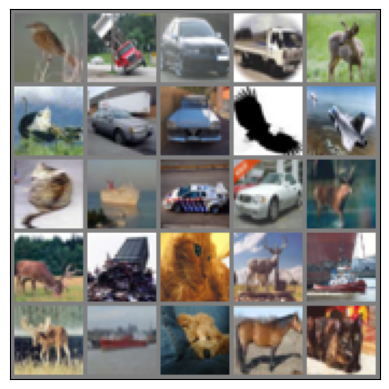

['bird', 'truck', 'car', 'truck', 'deer']
['bird', 'car', 'car', 'bird', 'plane']
['cat', 'ship', 'car', 'car', 'deer']
['deer', 'truck', 'cat', 'deer', 'ship']
['deer', 'ship', 'dog', 'horse', 'cat']


In [121]:
  # Show one batch of random training images
def show_images(imgs: torch.Tensor) -> None:
    imgs = imgs/2 + 0.5  # Unnormalize images
    plt.imshow(np.transpose(imgs.numpy(), (1, 2, 0)))
    plt.tick_params(axis='both',
                    which='both',
                    left=False,
                    labelleft=False,
                    bottom=False,
                    labelbottom=False)
    plt.savefig(os.path.join(output_directory, '1_some_images.png'),
                bbox_inches='tight', dpi=600)
    plt.show()

n_row = 5
data_iter = iter(train_loader)
images, labels = next(data_iter)
img_grid = torchvision.utils.make_grid(images[0:n_row**2], nrow=n_row)
show_images(img_grid)

classes_plot = [classes[i] for i in labels.numpy().astype(int)]
count = 0
for i in range(n_row):
    start_idx = n_row*i
    end_idx = start_idx + n_row
    print(classes_plot[start_idx:end_idx])

## Convolutional neural network (CNN)

In [123]:
class ConvolutionalNeuralNetwork(nn.Module):
    """
    Convolutional neural network.
    """
    def __init__(self,
                 input_size: int,
                 pixel_size: int,
                 num_classes: int) -> None:
        super().__init__()

        # Hyperparameters
        conv_kernel_size = 3
        pool_size = 2
        hidden_size_1 = 32
        hidden_size_2 = 64
        hidden_size_3 = 128
        hidden_size_fc = 64

        # Activation function
        self.activation = nn.ReLU()

        # Convolutional layers
        self.conv_1 = nn.Conv2d(input_size, hidden_size_1, conv_kernel_size)
        self.conv_2 = nn.Conv2d(hidden_size_1, hidden_size_2, conv_kernel_size)
        self.conv_3 = nn.Conv2d(hidden_size_2, hidden_size_3, conv_kernel_size)

        # Pooling layer
        self.pool = nn.MaxPool2d(pool_size, pool_size)

        # We keep track of output_size, i.e., what pixel_size becomes 
        # throughout the network layers, to know which input size value 
        # input_size_linear to set for the first fully connected layer self.fc1 below
        output_size = pixel_size - (conv_kernel_size - 1)  # After conv_1
        output_size = np.floor((output_size - pool_size)/pool_size + 1).astype(int)  # After pooling
        output_size -= (conv_kernel_size - 1)  # After conv_2
        output_size = np.floor((output_size - pool_size)/pool_size + 1).astype(int)  # After pooling
        output_size -= (conv_kernel_size - 1)  # After conv_3

        if output_size <= 0:
            raise ValueError('output_size <= 0, check other dimensions to get output_size > 0')
        
        # We flatten the output of the convolutional layers
        input_size_flatten = hidden_size_3*output_size*output_size

        # Fully connected layers for classification
        self.fc_1 = nn.Linear(input_size_flatten, hidden_size_fc)
        self.fc_2 = nn.Linear(hidden_size_fc, num_classes)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has size (N=batch_size, 3, 32, 32)
        # (Output sizes indicated below assuming conv_kernel_size = 3,
        #  pool_size = 2, hidden_size_1 = 32, hidden_size_2 = 64)
        x = self.activation(self.conv_1(x))  # (N, 32, 30, 30)
        x = self.pool(x)                     # (N, 32, 15, 15)
        x = self.activation(self.conv_2(x))  # (N, 64, 13, 13)
        x = self.pool(x)                     # (N, 64, 6, 6)
        x = self.activation(self.conv_3(x))  # (N, 64, 4, 4)
        x = torch.flatten(x, 1)              # (N, 1024)
        x = self.activation(self.fc_1(x))    # (N, 64)
        x = self.fc_2(x)                     # (N, num_classes)
        return x

In [128]:
# Define model
model = ConvolutionalNeuralNetwork(input_size, pixel_size, num_classes).to(device)

# Training
num_epochs = 15
learning_rate = 0.001
cross_entropy_loss = nn.CrossEntropyLoss()  # Multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_training_samples = len(train_loader.dataset)
print(f'Training over {n_training_samples} images:')
for epoch in range(num_epochs):
    running_loss = 0.
    for images, labels in train_loader:
        # Transfer to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss: torch.Tensor = cross_entropy_loss(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}]: '
            + f'loss = {running_loss/n_training_samples:.4f}')

Training over 50000 images:
Epoch [1/15]: loss = 0.0459
Epoch [2/15]: loss = 0.0342
Epoch [3/15]: loss = 0.0287
Epoch [4/15]: loss = 0.0251
Epoch [5/15]: loss = 0.0225
Epoch [6/15]: loss = 0.0205
Epoch [7/15]: loss = 0.0187
Epoch [8/15]: loss = 0.0171
Epoch [9/15]: loss = 0.0157
Epoch [10/15]: loss = 0.0146
Epoch [11/15]: loss = 0.0133
Epoch [12/15]: loss = 0.0121
Epoch [13/15]: loss = 0.0111
Epoch [14/15]: loss = 0.0101
Epoch [15/15]: loss = 0.0094


Classification report on the 10000 test images:
              precision    recall  f1-score   support

           0      0.790     0.753     0.771      1000
           1      0.867     0.834     0.850      1000
           2      0.710     0.577     0.637      1000
           3      0.586     0.519     0.551      1000
           4      0.633     0.730     0.678      1000
           5      0.640     0.676     0.657      1000
           6      0.779     0.820     0.799      1000
           7      0.759     0.794     0.776      1000
           8      0.807     0.850     0.828      1000
           9      0.801     0.820     0.810      1000

    accuracy                          0.737     10000
   macro avg      0.737     0.737     0.736     10000
weighted avg      0.737     0.737     0.736     10000



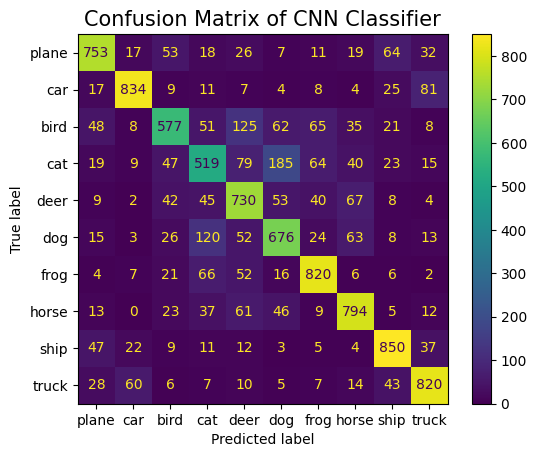

In [129]:
# Evaluation
all_predictions = []
all_labels = []

with torch.no_grad():
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)

        # max returns (output_value, index)
        _, predictions = torch.max(outputs, 1)

        all_predictions.append(predictions.cpu().numpy().tolist())
        all_labels.append(labels.cpu().numpy().tolist())
    
# Flatten predictions and labels
all_predictions = [x for item in all_predictions for x in item]
all_labels = [x for item in all_labels for x in item]

print(f'Classification report on the {n_samples} test images:')
print(classification_report(all_labels, all_predictions, digits=3))

confusion_mat = confusion_matrix(y_true=all_labels, y_pred=all_predictions)
disp = ConfusionMatrixDisplay(
    confusion_mat,
    display_labels=classes)
disp.plot()
plt.title('Confusion Matrix of CNN Classifier', fontsize=15)
plt.savefig(os.path.join(output_directory, '2_cnn_confusion_matrix.png'),
            bbox_inches='tight', dpi=600)
plt.show()

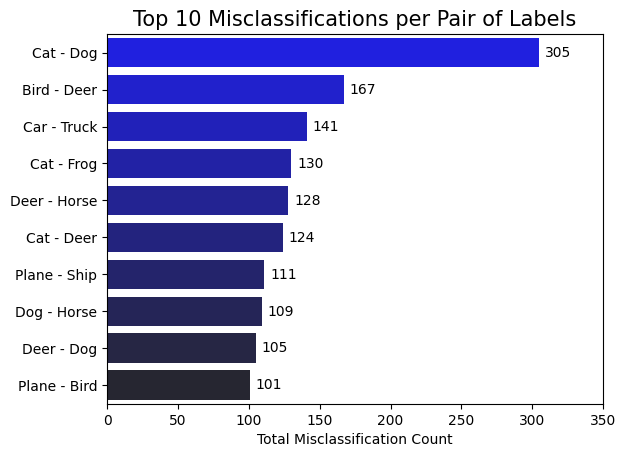

In [167]:
# Most prevalent misclassifications
class_labels = np.arange(num_classes)
miscl = []
for i in range(num_classes-1):
    for j in range(i+1, num_classes):
        count = confusion_mat[i, j] + confusion_mat[j, i]
        miscl.append([i, j, count])

miscl = np.array(miscl)
miscl = miscl[miscl[:, -1].argsort()[::-1]]

n_plot = 10

sns.barplot(x=miscl[:(n_plot), -1], y=np.arange(n_plot), orient='h',
            hue=np.arange(n_plot), palette='dark:b_r', legend=False)
ylabels = [f'{classes[miscl[i, 0]].capitalize()} - {classes[miscl[i, 1]].capitalize()}' for i in range(n_plot)]

for idx, val in enumerate(miscl[:(n_plot), -1]):
    plt.text(val+4, idx, f'{val}', va='center')

plt.gca().set_yticks(plt.gca().get_yticks())  # To suppress a warning
plt.gca().set_yticklabels(ylabels)
plt.title(f'Top {n_plot} Misclassifications per Pair of Labels', fontsize=15)
plt.xlabel('Total Misclassification Count')
plt.xlim([0, 350])
plt.savefig(os.path.join(output_directory, '3_cnn_misclassification_count.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The CNN classifier has reached an accuracy of 73.7%.
- The cat and dog labels are the most likely labels to be misclassified as each other.